## Prototype of a real-time phase estimation algorithm
### detect the critical points of the oscillatory signal and map the cycle onto sample count

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.signal import hilbert, butter, sosfiltfilt, sosfilt, filtfilt, lfilter
import os
import pandas as pd

In [2]:
regr = LinearRegression()

In [66]:
central_freq = 6
sampling_rate = 1500
# slope = 2*pi / # of corresponding sample counts
default_slope = (2*np.pi)/(sampling_rate/central_freq)
# ignoring the computation time, 62 samples every quarter cycle

num_to_wait = 5
regr_buffer_size = 15
fltr_buffer_size = 300

### create data

In [67]:
t = np.linspace(0, 10, sampling_rate*10)
x = np.sin(2*np.pi*central_freq*t)

### load data

In [68]:
%cd C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\theta_range_sample_data
data_dir = %pwd

data_list = [pd.read_csv(file) for file in next(os.walk(data_dir))[2]]
data_list = [file.iloc[:,0].tolist() for file in data_list]
time_list = [np.arange(len(data))/sampling_rate for data in data_list]

%cd C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\METHODS\clc\offline_analysis

C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\DATA\theta_range_sample_data
C:\Users\mengz\Box\Jhan\ClosedLoopControl Project\METHODS\clc\offline_analysis


### Non-causal global filtering

In [69]:
order = 1
lowcut = 4
highcut = 8

butter_filter = butter(order,[lowcut,highcut],'bp',fs=sampling_rate,output='sos')

filtered_data = [sosfiltfilt(butter_filter,data) for data in data_list]

<IPython.core.display.Javascript object>


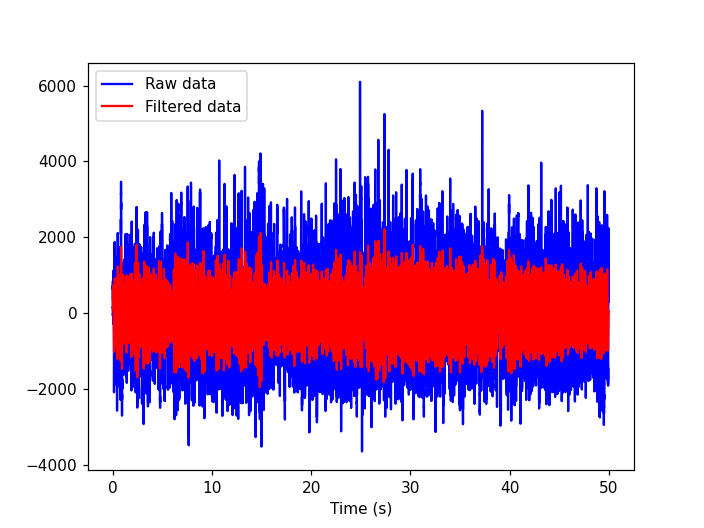

In [98]:
%matplotlib notebook

data_index = 1

plt.plot(time_list[data_index],data_list[data_index],color='b',label='Raw data')
plt.plot(time_list[data_index],filtered_data[data_index],color='r',label='Filtered data')
plt.xlabel('Time (s)')
plt.legend()

## Simulation

In [71]:
# x = data_list[data_index]
x = filtered_data[data_index]
t = time_list[data_index]

### Stepwise filtering (for display purpose)

In [72]:
# try stepwise filtering
stepwise_filtered = []

for i in range(fltr_buffer_size,len(t)):
    current_buffer = x[i-fltr_buffer_size:i]
    current_filtered = sosfiltfilt(butter_filter,current_buffer)
    stepwise_filtered.append(current_filtered[-1])

<IPython.core.display.Javascript object>


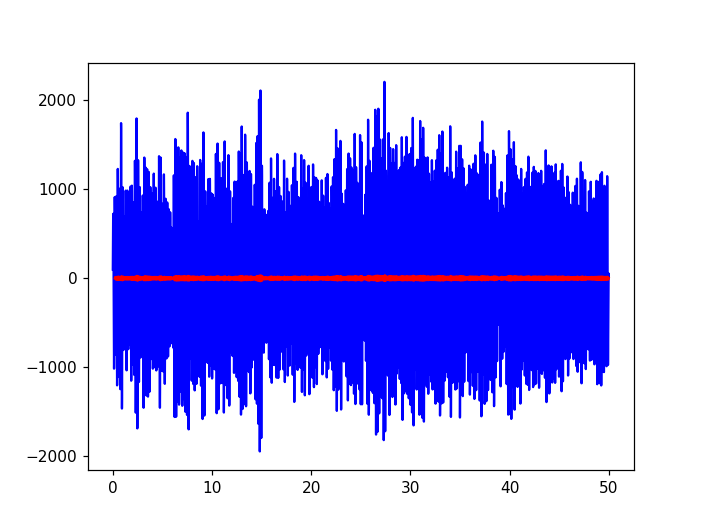

In [97]:
%matplotlib notebook

# plt.plot(t,data_list[data_index],color='k')
plt.plot(t,filtered_data[data_index],color='b')
plt.plot(t[fltr_buffer_size:],stepwise_filtered,color='r')

### Stepwise derivative

In [74]:
derivative_history = []
sample_axis = np.arange(regr_buffer_size).reshape(-1,1)

stepwise_filtering = True

if stepwise_filtering:
    for i in range(fltr_buffer_size,len(t)):
        current_buffer = x[i-fltr_buffer_size:i]
        current_filtered = sosfilt(butter_filter,current_buffer)
        regr.fit(sample_axis,current_filtered[len(current_filtered)-regr_buffer_size:])
        derivative_history.append(regr.coef_)
else:
    for i in range(regr_buffer_size,len(t)):
        current_buffer = x[i-regr_buffer_size:i]
        regr.fit(sample_axis,current_buffer)
        derivative_history.append(regr.coef_)
        
for i in range(len(derivative_history)):
    derivative_history[i] = derivative_history[i][0]

In [75]:
exact_derivative = np.gradient(filtered_data[data_index],1)

<IPython.core.display.Javascript object>


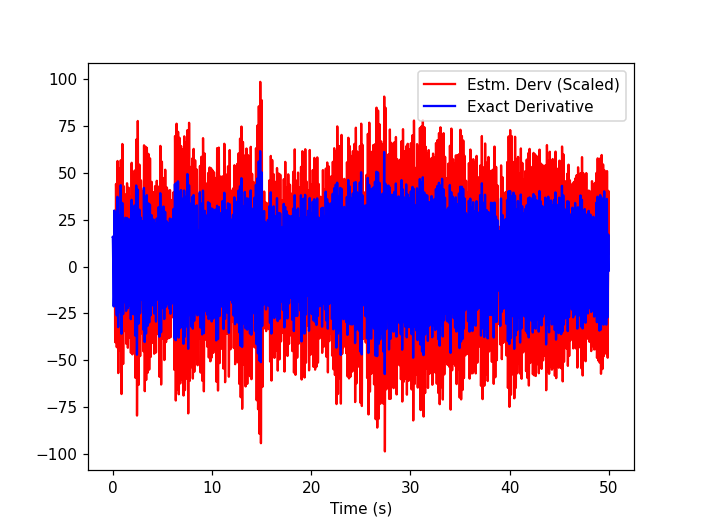

In [96]:
%matplotlib notebook

#plt.plot(t,filtered_data[data_index],color='k',label='Filtered Signal')

if stepwise_filtering:
    plt.plot(t[int(fltr_buffer_size-regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history)*2,\
             color='r',label='Estm. Derv (Scaled)')
else:
    plt.plot(t[int(regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history)*2,\
             color='r',label='Estm. Derv (Scaled)')
    
plt.plot(t,exact_derivative,color='b',label='Exact Derivative')

# plt.plot(t,(central_freq)*2*np.pi*np.cos((central_freq)*2*np.pi*t),color='orange',label='Exact Derivative')

plt.xlabel('Time (s)')
plt.legend()

### Critical point detection

In [77]:
critical_time = []
current_sign = True
sign_buffer = []

for i in range(len(derivative_history)):
    # initialize sign buffer and current sign
    if i == 0:
        current_sign = (derivative_history[0]>0)
        sign_buffer = [derivative_history[0]>0]*num_to_wait
        continue
    
    # update sign buffer
    sign_buffer.append(derivative_history[i]>0)
    sign_buffer.pop(0)
    
    # determine if a critical point is passed
    # need more efficient execution for real time
    flip = True
    for sign in sign_buffer:
        if current_sign == sign:
            flip = False
            break
    
    # change current sign, note down lateset critical point
    if flip:
        # take the start of num_to_wait consecutive changed signs as the critical point
        critical_time.append(t[i+int(regr_buffer_size/2)-num_to_wait])
        current_sign = sign_buffer[-1]
        
    # the systematic delay is num_to_wait + regr_buffer_size/2

<IPython.core.display.Javascript object>


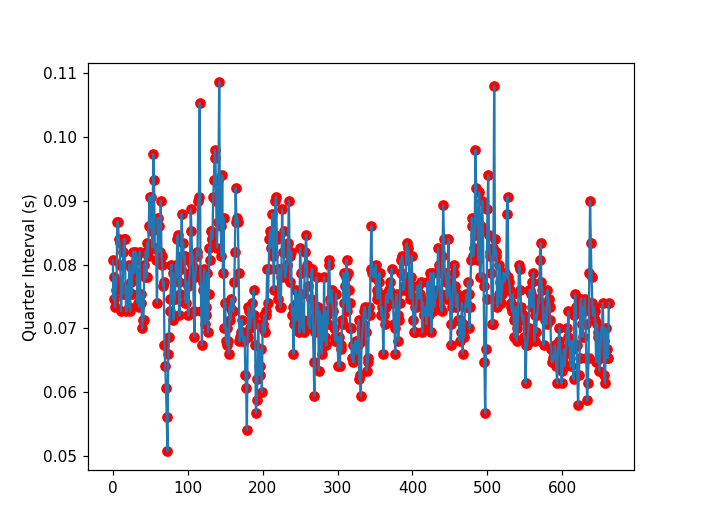

Text(0, 0.5, 'Quarter Interval (s)')

In [95]:
%matplotlib notebook

interval = np.diff(critical_time)
plt.plot(np.arange(len(interval)),interval)
plt.scatter(np.arange(len(interval)),interval,c='r')
plt.ylabel('Quarter Interval (s)')

<IPython.core.display.Javascript object>


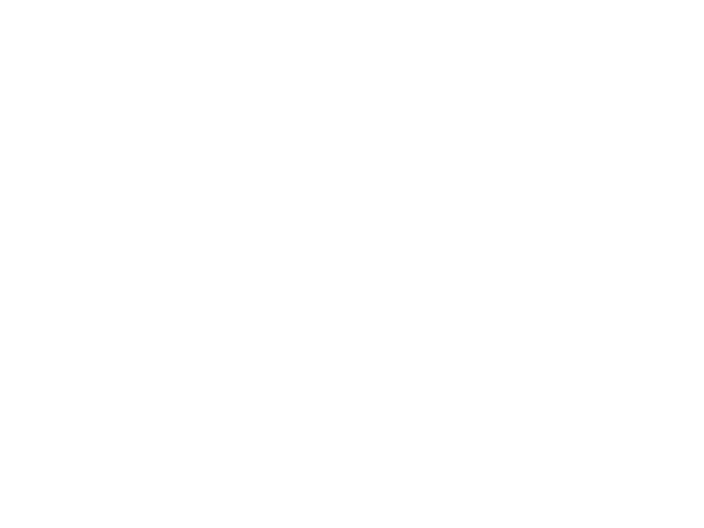

In [79]:
%matplotlib notebook

plt.plot(t,filtered_data[data_index],color='b',label='Filtered Signal')

if stepwise_filtering:
    plt.plot(t[int(fltr_buffer_size-regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history)*2,\
             color='r',label='Estm. Derv (Scaled)')
else:
    plt.plot(t[int(regr_buffer_size/2):int(len(t)-regr_buffer_size/2)],np.array(derivative_history)*2,\
             color='r',label='Estm. Derv (Scaled)')

plt.scatter(critical_time,[0]*len(critical_time),s=20,color='orange',label='Estimated Critical')
plt.legend()

### Slope update

In [80]:
slope_history = [default_slope]

for i in range(1,len(critical_time)):
    current_interval = (critical_time[i] - critical_time[i-1])*sampling_rate
    current_slope = np.pi/current_interval
    slope_history.append(current_slope)

In [81]:
if len(critical_time) == len(slope_history):
    test = dict(zip(critical_time,slope_history))

### Phase interpolation

In [82]:
initial_phase = None
next_critical_phase = None
last_critical_phase = None
# if the derivative starts positive, the next critical point should be pi; otherwise it's 0 (2pi)

if derivative_history[0]>0:
#     initial_phase = 0
#     last_critical_phase = 0
#     next_critical_phase = np.pi
    
    initial_phase = np.pi
    last_critical_phase = np.pi
    next_critical_phase = 0
else:
#     initial_phase = 0
#     last_critical_phase = 0
#     next_critical_phase = np.pi

    initial_phase = np.pi
    last_critical_phase = np.pi
    next_critical_phase = 0

In [83]:
phase_history = [initial_phase]
last_critical_point = 0
current_slope = default_slope

for time in t:
    
    if time <= critical_time[0]: continue
        
    # update current_slope upon passing each critical point
    try:
        if time == critical_time[last_critical_point+1]:
            last_critical_point = last_critical_point+1
            current_slope = test[critical_time[last_critical_point]]
            # correct phase at every critical point, which has known phase position
            last_critical_phase = next_critical_phase
            phase_history.append(next_critical_phase)
            next_critical_phase = (next_critical_phase + np.pi) % (2*np.pi)
            continue
            
    # for the last segment, last_critical_point + 1 would make index out of bound
    except IndexError:
        current_slope = test[critical_time[-1]]
        
    
    # calculate current phase based on current slope
    # multiply total_time_elapsed by sampling rate because the slope is phase vs. sample count
    
    #current_phase = (initial_phase+(time-critical_time[0])*sampling_rate*current_slope) % (2*np.pi)
    current_phase = last_critical_phase + (time-critical_time[last_critical_point])*sampling_rate*current_slope
    phase_history.append(current_phase)

<IPython.core.display.Javascript object>


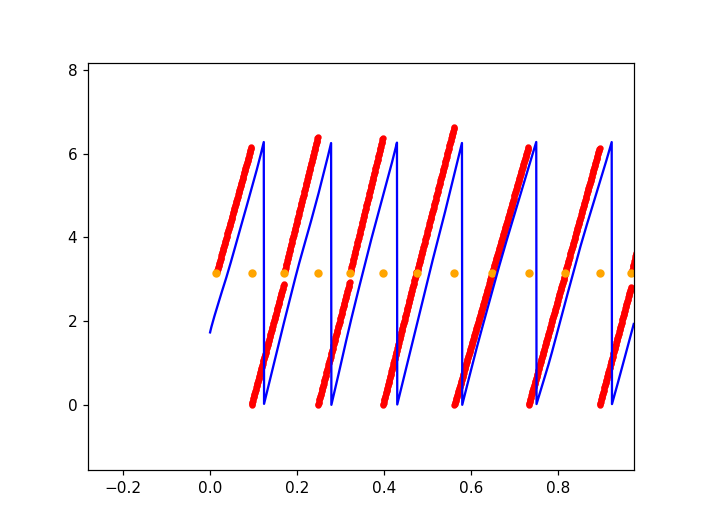

In [94]:
%matplotlib notebook

phase_detection_start = 0
for i in range(len(t)):
    if critical_time[0] == t[i]:
        phase_detection_start = i
        break

exact_phase = np.angle(hilbert(filtered_data[data_index]))+np.pi

plt.plot(t,exact_phase,color='b',label='Exact phase')
plt.scatter(t[phase_detection_start:],phase_history,s=10,color='r',label='Estimated phase')
plt.scatter(critical_time,[np.pi]*len(critical_time),s=20,color='orange',label='Estimated Critical')
# plt.legend()

## Analysis

### Critical points

In [85]:
# the magnitude of derivative is messed up, but critical points should not be affeced
critical_time_truth = []

# detect critical points with ground truth derivative
current_sign = (exact_derivative[0]>0)
for i in range(len(exact_derivative)):
    if not ((exact_derivative[i]>0) == current_sign):
        critical_time_truth.append(t[i-1])
        current_sign = (exact_derivative[i]>0)

In [86]:
print(len(critical_time_truth))
print(len(critical_time))

667
664


<IPython.core.display.Javascript object>


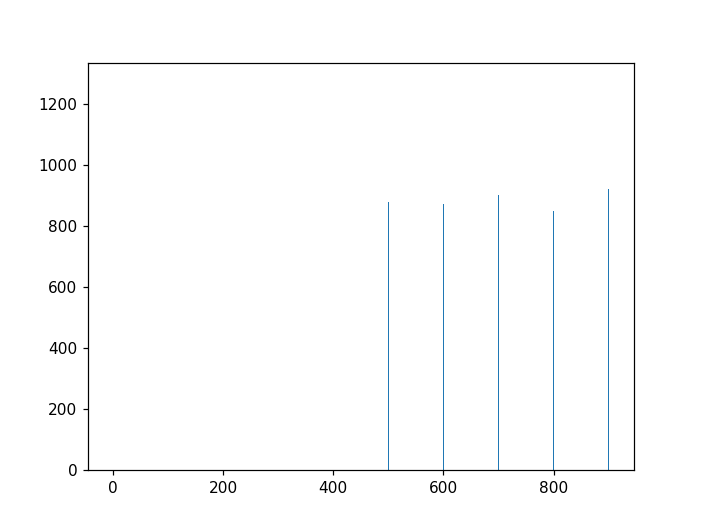

<BarContainer object of 10 artists>

In [90]:
%matplotlib notebook

cross_correlation = [(time_1 - time_2)*1000 for time_1 in critical_time_truth for time_2 in critical_time]
diff_bar_critical, bin_edges_critical = np.histogram(cross_correlation, range=(0,1000))
plt.bar(bin_edges_critical[:-1],diff_bar_critical)

# estimated critical time is shifted for better view
# plt.scatter(np.arange(len(critical_time)),np.array(critical_time)+1,s=0.2)
# plt.scatter(np.arange(len(critical_time_truth)),critical_time_truth,s=0.2)

### Phase

In [93]:
# Mean squared error (rad)
MSE = np.square(np.subtract(exact_phase[phase_detection_start:],phase_history)).mean()
MSE

6.6081751482039595

<IPython.core.display.Javascript object>


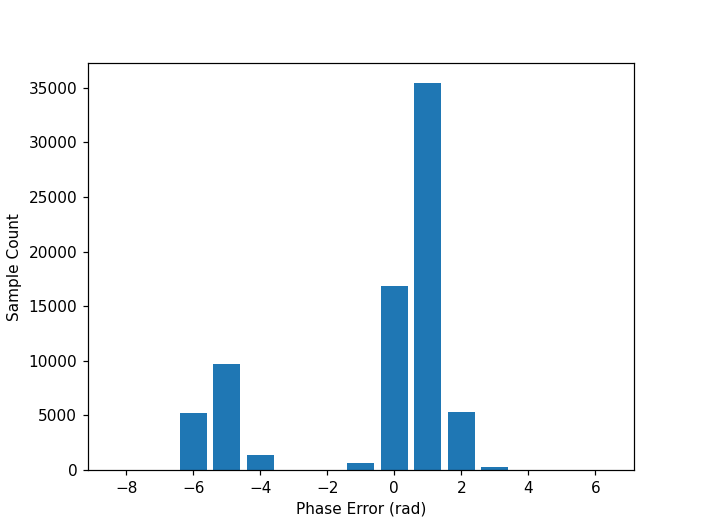

Text(0, 0.5, 'Sample Count')

In [92]:
# Phase cross correlation
%matplotlib notebook

diff_bar_phase, bin_edges_phase = np.histogram(np.subtract(phase_history,exact_phase[phase_detection_start:]), range(-8,8))
plt.bar(bin_edges_phase[:-1],diff_bar_phase)
plt.xlabel('Phase Error (rad)')
plt.ylabel('Sample Count')